In [1]:
! pip install langgraph langchain_core langchain-google-genai

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
import os
from dotenv import load_dotenv

load_dotenv()

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools: list[tool] = [add, multiply, divide]
google_api = os.getenv('GEMINI_API_KEY')
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model ="gemini-1.5-flash",api_key=google_api)
llm_with_tools = llm.bind_tools(tools)

In [6]:
from langgraph.prebuilt import tools_condition, ToolNode

ToolNode

langgraph.prebuilt.tool_node.ToolNode

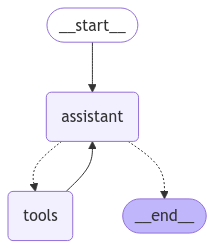

In [7]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph.state import CompiledStateGraph

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (d5c49e00-4c6b-4189-a7b6-a48cbe4d9896)
 Call ID: d5c49e00-4c6b-4189-a7b6-a48cbe4d9896
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result is 6.


In [9]:
graph.get_state({'configurable': {'thread_id': '1'}})


StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-cb1e4535-c963-428d-9d73-8426ce8aecfd-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'd5c49e00-4c6b-4189-a7b6-a48cbe4d9896', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 3, 'total_tokens': 169, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='6', name='multiply', id='575dc0b1-90f5-47e8-9f8e-5df05a84f5ef', tool_call_id='d5c49e00-4c6b-4189-a7b6-a48cbe4d9896'), AIMessage(content='The result is 6.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'fin

In [25]:
all_states = [s for s in graph.get_state_history(thread)]
to_replay =all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbc78f-9ec5-6cc6-8000-293cc941d6f2'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2024-12-17T13:15:24.688915+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbc78f-9dd1-6a9c-bfff-fb95b352e627'}}, tasks=(PregelTask(id='a58d5d73-af08-6a94-8dcd-32058e0be790', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, i

In [26]:
print(len(all_states))


5


In [27]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d')]}

In [28]:
to_replay.next


('assistant',)

In [29]:
to_replay.config


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbc78f-9ec5-6cc6-8000-293cc941d6f2'}}

In [30]:
to_fork = all_states[-2]
to_fork.values['messages']

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d')]

In [31]:
to_fork.config


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbc78f-9ec5-6cc6-8000-293cc941d6f2'}}

In [34]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3',
                               id=to_fork.values["messages"][0].id)]},
)
fork_config


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbc79f-fb9d-65d6-8001-c14da8bd72c6'}}

In [35]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d')]

In [36]:
graph.get_state({'configurable': {'thread_id': '1'}})


StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbc79f-fb9d-65d6-8001-c14da8bd72c6'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efbc78f-9ec5-6cc6-8000-293cc941d6f2'}, created_at='2024-12-17T13:22:43.920840+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbc78f-9ec5-6cc6-8000-293cc941d6f2'}}, tasks=(PregelTask(id='52228bc2-3adc-1457-b84b-3c42a4ecc598', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [37]:
graph.get_state({'configurable': {'thread_id': '1'}})


StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbc79f-fb9d-65d6-8001-c14da8bd72c6'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='ac74c0e2-ad32-45c2-95f7-e18e10841e0d')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efbc78f-9ec5-6cc6-8000-293cc941d6f2'}, created_at='2024-12-17T13:22:43.920840+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbc78f-9ec5-6cc6-8000-293cc941d6f2'}}, tasks=(PregelTask(id='52228bc2-3adc-1457-b84b-3c42a4ecc598', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))